# Analisis Exploratorio de Datos (Casas Idealista)

In [274]:
# Librerías de manipulación de tablas, datos y fórmulas
import pandas as pd
import numpy as np
# Librería para utilizar expresiones regulares
import re
# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Librerias de Machine Leaarning 
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats

In [275]:
df_casas3 = pd.read_excel('casas_idealista_limpio.xlsx')

In [276]:
df_casas3.head()

,titulo,localizacion,precio,metros_cuadrados,habitaciones,baños,ascensor,año,trastero,orientacion,piso,metros_reales,condicion,armarios_empotrados,terraza,balcon,jardin,garaje,calefaccion,aire_acondicionado
0,Piso en venta en calle de l'Arxiduc Carles,Safranar,225000,108,4,2,1,1976,0,sur,Solo acceso exterior adaptado para personas co...,108,Segunda mano/buen estado,0,0,1,0,0,1,1
1,Piso en venta en calle de l'Arxiduc Carles,Safranar,225000,108,4,2,1,1976,0,sur,Solo acceso exterior adaptado para personas co...,108,Segunda mano/buen estado,0,0,1,0,0,1,1
2,Ático en venta en plaza de Josep Melia i Castello,Sant Isidre,150000,116,1,1,1,2008,0,este,Solo acceso exterior adaptado para personas co...,116,Segunda mano/buen estado,1,1,1,0,0,1,1
3,Piso en venta en calle de Fra Juníper Serra,Vara de Quart,210000,118,4,2,1,1977,0,oeste,Planta 7ª exterior,118,Segunda mano/buen estado,0,0,1,0,0,1,1
4,Piso en venta en Sant Isidre,Patraix,168000,95,2,1,1,1999,0,sur,Solo acceso exterior adaptado para personas co...,95,Segunda mano/buen estado,1,0,1,0,1,1,1


In [277]:
# Miro la clase de datos que tengo y si existen NaNs
df_casas3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   titulo               265 non-null    object
 1   localizacion         265 non-null    object
 2   precio               265 non-null    int64 
 3   metros_cuadrados     265 non-null    int64 
 4   habitaciones         265 non-null    int64 
 5   baños                265 non-null    int64 
 6   ascensor             265 non-null    int64 
 7   año                  265 non-null    int64 
 8   trastero             265 non-null    int64 
 9   orientacion          128 non-null    object
 10  piso                 262 non-null    object
 11  metros_reales        265 non-null    int64 
 12  condicion            265 non-null    object
 13  armarios_empotrados  265 non-null    int64 
 14  terraza              265 non-null    int64 
 15  balcon               265 non-null    int64 
 16  jardin  

##### Como podemos observar tenemos nulls en 'orientación' y 'piso'. En 'piso' son solo 3 los nulls, por lo tanto, no perdemos mucha información si los eliminamos. En 'orientación' son muchos como para eliminarlos, así que imputaremos a los nulls el valor neutro de 'desconocido', y luego veremos si tiene correlación con la variable a predecir 'precio', y si vieramos que no tiene correlación suficiente, excluiríamos la variable del modelo.

##### En 'año' hay muchos valores 0 que pertenecen a pisos de obra nueva que no tienen el año actualizado, así que tomaremos la variable 'condicion' para detectar los pisos de obra nueva y cambiarles el año al 2023.

In [278]:
# Creo función para cambiar el año de construcción de los valores de 'obra nueva' en la variable 'condicion' 
def actualizar_año(row):
    if "obra" in row['condicion'].lower():
        row['año'] = 2023
    return row
# Aplico la función
df_casas3 = df_casas3.apply(actualizar_año, axis=1)

In [279]:
# Reemplazo NaN en la columna 'orientacion' con 'Desconocida'
df_casas3['orientacion'].fillna('Desconocida', inplace=True)
# Elimino filas con valores nulos en la columna 'pisos'
df_casas3 = df_casas3.dropna(subset=['piso'])

In [280]:
# Visualizo los valores de 'condicion'
df_casas3['condicion'].value_counts()

Segunda mano/buen estado      207
Promoción de obra nueva        28
Segunda mano/para reformar     27
Name: condicion, dtype: int64

In [281]:
# Voy a eliminar del listado los duplex, pues la valoración de estos inmuebles no tiene la misma linea, pues son plantas bajas 
# con el valor de un ático, y pueden trastocar los resultados del modelo.
df_casas3 = df_casas3[~df_casas3['titulo'].str.contains('Dúplex', case=True, na=False)]

In [282]:
# Elimino los pisos que en la variable 'piso', solo nos informa de que hay acceso a personas con movilidad reducida, 
# y no nos dice el piso real.
df_casas3 = df_casas3[~df_casas3['piso'].str.contains('personas con movilidad')]

In [283]:
# Visualizo los valores de 'piso'
df_casas3['piso'].value_counts()

Planta 2ª exterior     33
Planta 1ª exterior     29
Planta 6ª exterior     23
Planta 3ª exterior     19
Planta 4ª exterior     19
Planta 5ª exterior     18
Planta 7ª exterior     15
Planta 8ª exterior      9
Bajo exterior           8
Planta 2ª               3
Planta 5ª               3
Planta 1ª interior      2
Planta 8ª               2
Planta 13ª exterior     1
Planta 11ª exterior     1
Planta 2ª interior      1
Planta 4ª               1
Planta -1 exterior      1
Planta 6ª interior      1
Planta 3ª               1
Planta 5ª interior      1
Name: piso, dtype: int64

#### Voy a crear una nueva variable de cuatro categorías, a partir de la variable 'piso', para poder diferenciar las alturas y tenerlos mas ordenados. Especificaré las plantas bajas, los pisos bajos del 1º al 3º, los pisos medios del 4º al 6º, y los pisos altos del 7º hasta el último.

In [284]:
# Creo función para categorizar la variable 'piso'
def categorizar_piso(valor):
    if "Bajo" in valor or "Planta -1" in valor:
        return "PLANTA BAJA"
    elif "Planta 1ª" in valor or "Planta 2ª" in valor or "Planta 3ª" in valor:
        return "PISOS BAJOS"
    elif "Planta 4ª" in valor or "Planta 5ª" in valor or "Planta 6ª" in valor:
        return "PISOS MEDIOS"
    else:
        return "PISOS ALTOS"
# Aplico función y almaceno en nueva variable 'altura_piso'
df_casas3['altura_piso'] = df_casas3['piso'].apply(categorizar_piso)

In [285]:
# Ahora ya puedo eliminar la variable piso, pues ya no la voy a utilizar
df_casas3.drop('piso', axis=1, inplace=True)

In [286]:
df_casas3.head()

,titulo,localizacion,precio,metros_cuadrados,habitaciones,baños,ascensor,año,trastero,orientacion,metros_reales,condicion,armarios_empotrados,terraza,balcon,jardin,garaje,calefaccion,aire_acondicionado,altura_piso
3,Piso en venta en calle de Fra Juníper Serra,Vara de Quart,210000,118,4,2,1,1977,0,oeste,118,Segunda mano/buen estado,0,0,1,0,0,1,1,PISOS ALTOS
6,"Piso en venta en avenida Pérez Galdós, 33",Patraix,336500,141,3,2,1,2023,0,Desconocida,141,Promoción de obra nueva,0,1,0,0,0,0,0,PISOS BAJOS
7,"Piso en venta en avenida Pérez Galdós, 33",Patraix,341500,141,3,2,1,2023,0,Desconocida,141,Promoción de obra nueva,0,1,0,0,0,0,0,PISOS BAJOS
8,Ático en venta en calle josep melia y castello,Sant Isidre,150000,66,1,1,1,0,0,Desconocida,66,Segunda mano/buen estado,0,1,0,0,0,1,1,PISOS ALTOS
9,"Piso en venta en avenida Pérez Galdós, 33",Patraix,356500,150,3,2,1,2023,0,Desconocida,150,Promoción de obra nueva,0,1,0,0,0,0,0,PISOS BAJOS


In [287]:
# Me hago un sumario estadistico de las variables que tengo, para tener una vista general de los datos.
df_casas3.describe()

,precio,metros_cuadrados,habitaciones,baños,ascensor,año,trastero,metros_reales,armarios_empotrados,terraza,balcon,jardin,garaje,calefaccion,aire_acondicionado
count,191.000000,191.000000,191.000000,191.000000,191.00000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.0,191.000000,191.000000,191.000000
mean,210716.712042,107.471204,3.068063,1.675393,0.91623,1342.691099,0.073298,107.471204,0.434555,0.471204,0.450262,0.0,0.225131,0.460733,0.554974
std,77726.393606,26.700640,0.968219,0.512344,0.27777,933.484719,0.261311,26.700640,0.497001,0.500482,0.498828,0.0,0.418766,0.499766,0.498275
min,55100.000000,55.000000,1.000000,1.000000,0.00000,0.000000,0.000000,55.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,162500.000000,90.000000,3.000000,1.000000,1.00000,0.000000,0.000000,90.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,195000.000000,107.000000,3.000000,2.000000,1.00000,1974.000000,0.000000,107.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
75%,230000.000000,122.500000,4.000000,2.000000,1.00000,1990.500000,0.000000,122.500000,1.000000,1.000000,1.000000,0.0,0.000000,1.000000,1.000000
max,575000.000000,218.000000,6.000000,4.000000,1.00000,2023.000000,1.000000,218.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


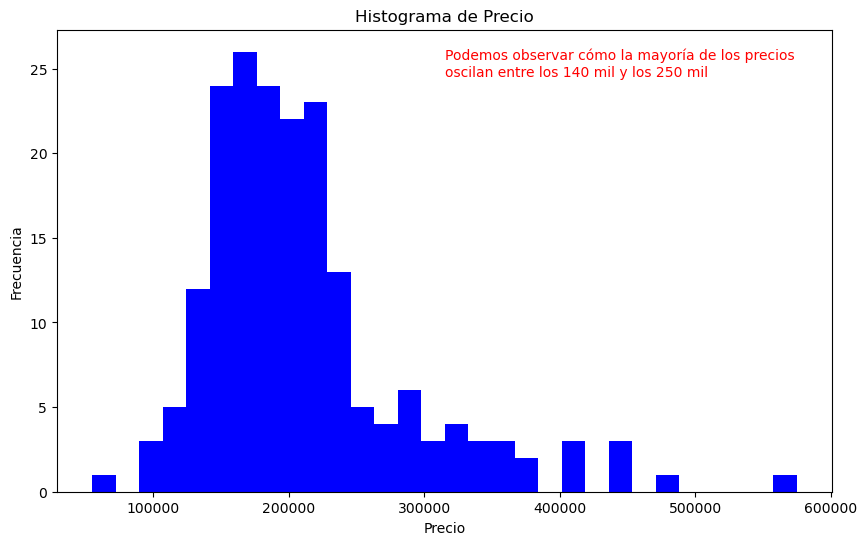

In [288]:
# Voy a crear un histograma de la variable target
# Doy tamaño
plt.figure(figsize=(10, 6))
# Elijo gráfico histograma y sus atributos
plt.hist(df_casas3['precio'], bins=30, color='blue')
# Añado título y etiquetas x/y
plt.title('Histograma de Precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
# Agrego observación
plt.annotate('Podemos observar cómo la mayoría de los precios\noscilan entre los 140 mil y los 250 mil',
             xy=(0.5, 0.9), xycoords='axes fraction', fontsize=10, color='red')

plt.show()

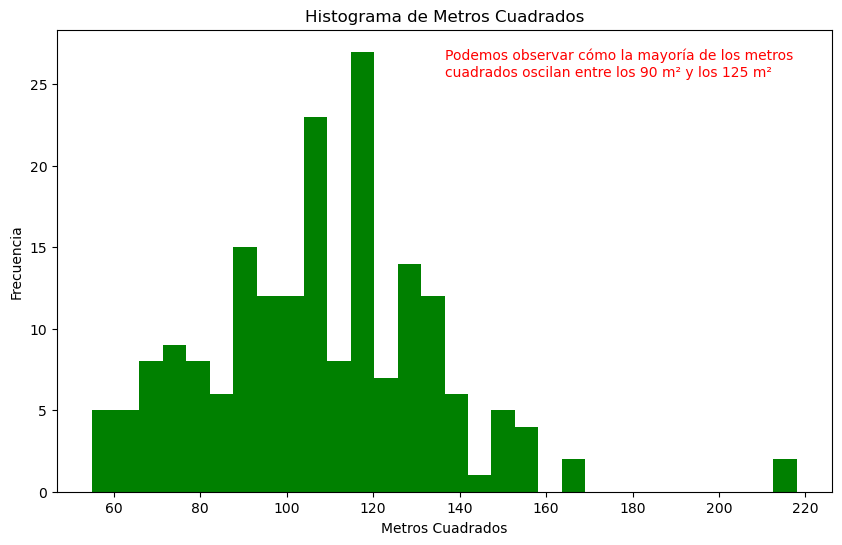

In [289]:
# Ahora creo otro de la variable metros_cuadrados
plt.figure(figsize=(10, 6))
plt.hist(df_casas3['metros_cuadrados'], bins=30, color='green')
plt.title('Histograma de Metros Cuadrados')
plt.xlabel('Metros Cuadrados')
plt.ylabel('Frecuencia')
# Agrego observación
plt.annotate('Podemos observar cómo la mayoría de los metros\ncuadrados oscilan entre los 90 m² y los 125 m²',
             xy=(0.5, 0.9), xycoords='axes fraction', fontsize=10, color='red')

plt.show()

In [290]:
# Configuro lista de atributos
atributos = ['precio', 'metros_cuadrados', 'habitaciones', 'ascensor', 'año', 'terraza', 'balcon', 'garaje', 'calefaccion', 'aire_acondicionado']
atributos_df = df_casas3[atributos]

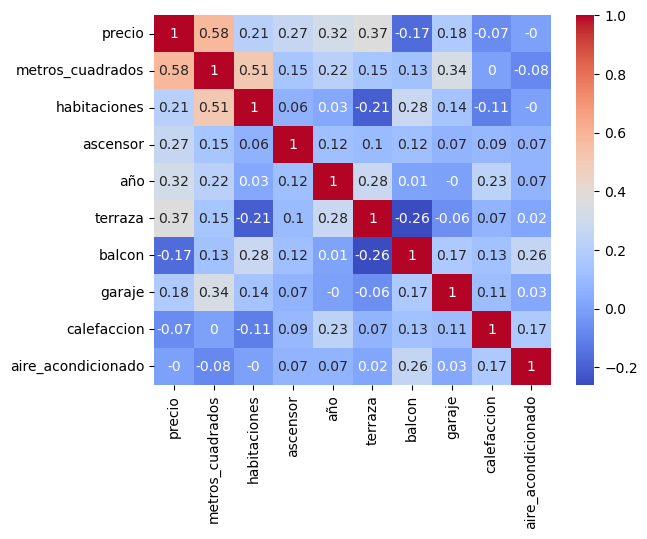

In [291]:
# Saco tabla de correlaciones
corrMatrix=df_casas3[atributos].corr().round(2)
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm')
plt.show()

#### Podemos observar como metros cuadrados, terraza y año son las variables que mas correlación tienen con el precio

In [292]:
# Aplico formula Z-Score para quitar los outliers con mas suavidad
# Calculo los valores Z para la columna 'precio'
z_scores = np.abs(stats.zscore(df_casas3['precio']))

# Defino un umbral Z para considerar los outliers
umbral_z = 2.25

# Filtro los datos para mantener solo aquellos que no son outliers
df_casas3 = df_casas3[z_scores <= umbral_z]

In [293]:
# Exporto el DataFrame a un archivo Excel
df_casas3.to_excel('casas_idealista_analisis.xlsx', index=False)
# Y a CSV
df_casas3.to_csv('casas_idealista_analisis.csv', index=False, sep=';', encoding='utf-16')

In [294]:
# Transformo 'condicion' y 'localizacion' en variables numericas o dummy, para prevenir errores
df_casas_num = pd.get_dummies(df_casas3, columns=['localizacion', 'condicion', 'orientacion', 'altura_piso'])

In [295]:
df_casas_num.head()

,titulo,precio,metros_cuadrados,habitaciones,baños,ascensor,año,trastero,metros_reales,armarios_empotrados,terraza,balcon,jardin,garaje,calefaccion,aire_acondicionado,localizacion_Barrio de Favara,localizacion_Patraix,localizacion_Safranar,localizacion_Sant Isidre,localizacion_Vara de Quart,condicion_Promoción de obra nueva,condicion_Segunda mano/buen estado,condicion_Segunda mano/para reformar,orientacion_Desconocida,orientacion_este,orientacion_norte,orientacion_oeste,orientacion_sur,altura_piso_PISOS ALTOS,altura_piso_PISOS BAJOS,altura_piso_PISOS MEDIOS,altura_piso_PLANTA BAJA
3,Piso en venta en calle de Fra Juníper Serra,210000,118,4,2,1,1977,0,118,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
6,"Piso en venta en avenida Pérez Galdós, 33",336500,141,3,2,1,2023,0,141,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
7,"Piso en venta en avenida Pérez Galdós, 33",341500,141,3,2,1,2023,0,141,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
8,Ático en venta en calle josep melia y castello,150000,66,1,1,1,0,0,66,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0
9,"Piso en venta en avenida Pérez Galdós, 33",356500,150,3,2,1,2023,0,150,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0


## Ajuste del Modelo de Regresión Ridge

In [296]:
# Defino mis variables, X serán todas las variables menos 'titulo' que no nos dice nada, y 'precio', que luego la defino como Y.
x, y = df_casas_num.drop(['precio','titulo'], axis=1), df_casas_num['precio']

In [297]:
# Creo una lista con todas las variables
vars_casas = list(df_casas_num.columns)
# Elimino de la lista las variables tarjet y categorica
vars_casas.remove('precio')
vars_casas.remove('titulo')

model intercept: 42497.646618


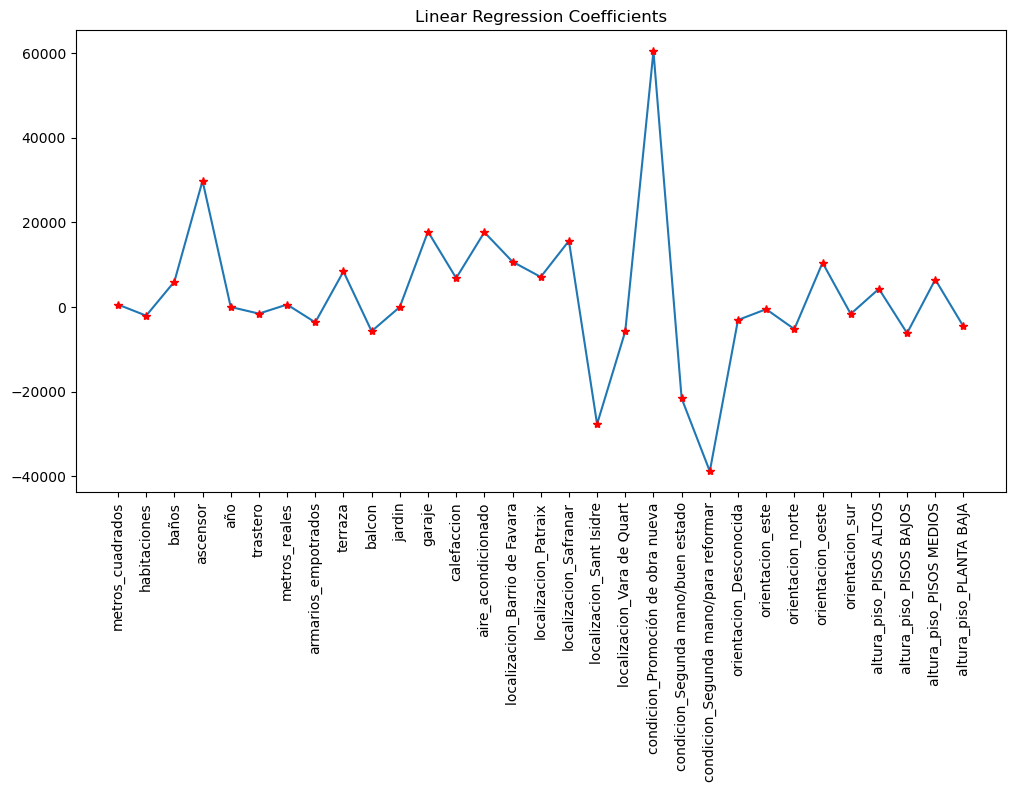

In [298]:
# Cargo el modelo 
lr_m = Ridge()
# Entreno el modelo con x, y
lr_m.fit(x,y)
print('model intercept: %f' % lr_m.intercept_)

# Creo un gráfico para representar los coeficientes. Configuro tamaño.
plt.figure(figsize=(12, 6))
# Establezco el eje y las etiquetas de X
plt.xticks(range(len(vars_casas)), vars_casas, rotation=90)
# Agrego título
plt.title('Linear Regression Coefficients')
# Agrego los coeficientes del modelo, marcando sus puntos en rojo
_ = plt.plot(lr_m.coef_.T, '-', lr_m.coef_.T, 'r*')

#### Aquí ya estamos observando que un piso de segunda mano con buen estado de forma ya tiene mucho más valor que uno para reformar, y como la 'condicion' promoción de obra nueva eleva mucho el precio. También vemos como las orientaciones oeste, sur y este, tienen más valor que la orientación norte, y que los pisos altos, o de altura media, son más caros que los bajos, y por lo tanto pierden valor. 

MAE: 23690.116	R^2: 0.746


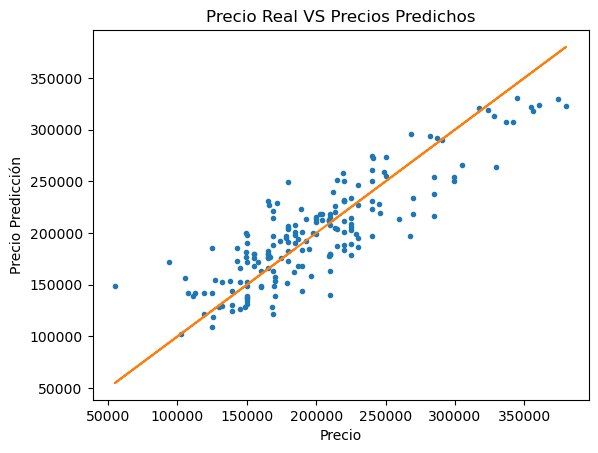

In [299]:
# Creo gráfico para ver la distribución de las predicciones del entrenamiento del modelo sobre los precios reales
y_pred = lr_m.predict(x)

print("MAE: %.3f\tR^2: %.3f" % (mean_absolute_error(y, y_pred), lr_m.score(x, y)))

plt.title('Precio Real VS Precios Predichos')
plt.xlabel('Precio')
plt.ylabel('Precio Predicción')
_ = plt.plot(y, y_pred, '.', y, y, '')

In [300]:
# Tenemos un buen MAE y R^2, ya que las predicciones estan hechas sobre precios que ya sabíamos, 
# pero ahora vamos a hacer las predicciones sobre pisos que no sean los mismos en los que se está entrenando el modelo, 
# utilizando la validación cruzada de manera aleatoria.
# Creo numero de folds, objeto Kfold e indico aleatoriedad
n_folds = 10
kf = KFold(n_folds, shuffle=True)
# Evaluo el modelo con la validación cruzada
scores = cross_val_score(lr_m, x, y, scoring = 'neg_mean_absolute_error', cv = kf, n_jobs = -1)
# Imprimo MAE y desviación estandar
print('mae_mean: %.3f\t\tmae_std: %.3f' % (-scores.mean(), scores.std()))
print('scores:\n', -np.round(scores, 3))

mae_mean: 28057.055		mae_std: 3104.368
scores:
 [29035.542 28854.864 30847.029 19643.131 29299.111 26877.612 26579.786
 29134.29  29386.371 30912.813]


#### Logicamente el MAE sube al predecir pisos sobre los que no se ha ajustado el modelo
#### Vamos a aplicar una tecnica que se llama 'fine tuning', o 'ajuste fino' para mejorar el MAE. El objetivo principal de éste método, es mejorar el rendimiento del modelo en una tarea específica, utilizando el conocimiento y las características aprendidas en el ajuste.

In [301]:
# Primera iteración para encontrar alpha
# Defino folds (particiones a iterar de manera aleatoria)
n_folds = 10
kf = KFold(n_folds, shuffle=True)

# Creo lista alpha con un rango a recorrer para encontrar el mejor alpha.
l_alpha = [2.**k for k in range (-6, 10)]
# Defino el param_grid, donde se almacenarán los posibles valores de alpha.
param_grid = {'alpha': l_alpha}

# Defino el grid search, que realizará una búsqueda de hiperparámetros utilizando validación cruzada k-fold.
lr_m = Ridge()
ridge_alpha_search = GridSearchCV(lr_m,
                                 param_grid = param_grid,
                                 cv = kf,
                                 scoring = 'neg_mean_absolute_error',
                                 n_jobs = -1,
                                 verbose = 1)
# Ajusto el modelo Ridge con los diferentes valores de "alpha"
_ = ridge_alpha_search.fit(x,y)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


alpha_range: 0.02 - 512.00
alpha = 4.00
best_cv_mae = 27686.180


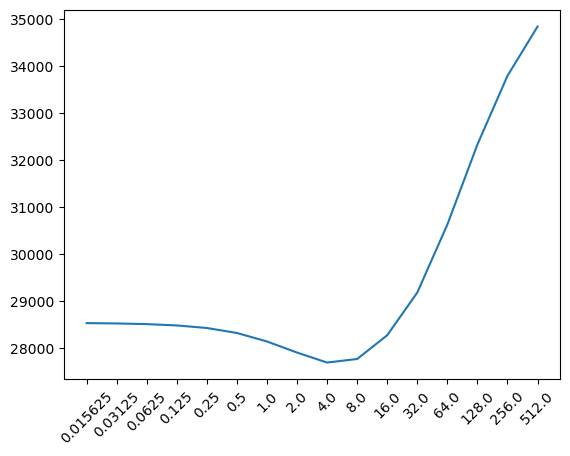

In [316]:
# Imprimo resultados
print('alpha_range: %.2f - %.2f' % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('alpha = %.2f' % (ridge_alpha_search.best_params_['alpha']))
print('best_cv_mae = %.3f' % (-ridge_alpha_search.best_score_))
# Creo gráfica para ver el mejor alpha
plt.xticks(range(len(l_alpha)), l_alpha, rotation = 45)
_ = plt.plot( -ridge_alpha_search.cv_results_['mean_test_score'])

#### En la gráfica podemos observar claramente el mejor alpha.

In [303]:
# Obtengo el mejor valor de alpha
best_alpha = ridge_alpha_search.best_params_['alpha']
# Creo nuevo modelo incluyendo alpha
lr_m = Ridge(alpha=best_alpha)
# Evaluo modelo con validación cruzada
scores = cross_val_score(lr_m, x, y, scoring = 'neg_mean_absolute_error', cv = kf, n_jobs = 2)
# Imprimpo MAE
print('mae_mean: %.3f\t\tmae_std: %.3f' % (-scores.mean(), scores.std()))

mae_mean: 27407.694		mae_std: 4139.631


#### Hemos podido reducir el MAE o error medio, un poco más.

In [304]:
# Realizo las predicciones con validación cruzada y las almaceno en una variable
y_pred = cross_val_predict(lr_m, x, y)

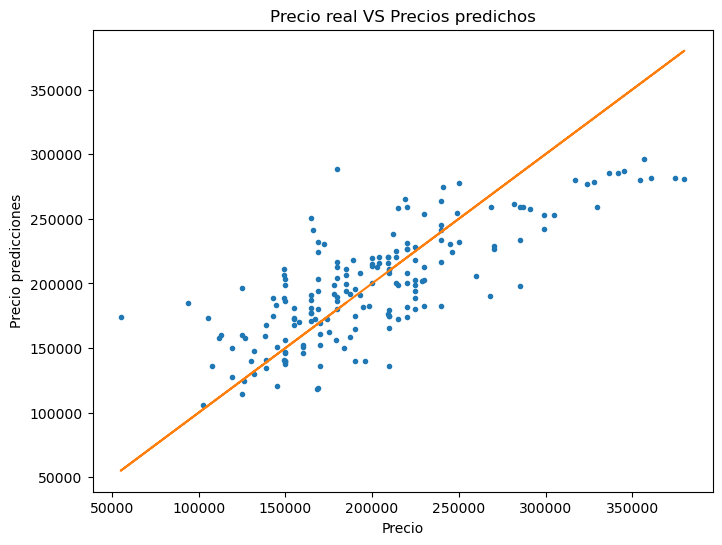

In [305]:
# Creo gráfico para visualizar las predicciones
plt.figure(figsize = (8,6))
plt.title('Precio real VS Precios predichos')
plt.xlabel('Precio')
plt.ylabel('Precio predicciones')
_ = plt.plot(y, y_pred, '.', y, y, '-')

#### Podemos observar que aunque tenemos algunos valores un poco alejados del acierto, también tenemos muchos que están muy cerca.

In [306]:
# Creo dataframe de las predicciones
df_preds = pd.DataFrame({'Predicciones': y_pred})
# Redondeo los valores de 'predicciones' para eliminar los decimales
df_preds['Predicciones'] = df_preds['Predicciones'].round(0)

In [307]:
# Creo índice nuevo para el dataframe
df_casas_pred = df_casas3.reset_index(drop = True, inplace = True)
# Creo nuevo dataframe y elimino las columnas que no me interesan para el dataframe de la comparativa de las predicciones
df_casas_pred = df_casas3.copy()
df_casas_pred = df_casas_pred.drop(columns = ['orientacion', 'localizacion', 'ascensor', 'baños', 'trastero', 'altura_piso',
                                              'habitaciones', 'metros_reales', 'condicion', 'armarios_empotrados', 'terraza', 
                                              'balcon', 'jardin', 'garaje', 'calefaccion', 'aire_acondicionado'])

In [308]:
# Uno los dos dataframes en uno
df_casas_final = df_casas_pred.merge(df_preds, left_index=True, right_index=True, how='inner')
df_casas_final.head()

,titulo,precio,metros_cuadrados,año,Predicciones
0,Piso en venta en calle de Fra Juníper Serra,210000,118,1977,210070.0
1,"Piso en venta en avenida Pérez Galdós, 33",336500,141,2023,285574.0
2,"Piso en venta en avenida Pérez Galdós, 33",341500,141,2023,285574.0
3,Ático en venta en calle josep melia y castello,150000,66,0,140301.0
4,"Piso en venta en avenida Pérez Galdós, 33",356500,150,2023,296123.0


In [309]:
# Configuro Pandas para mostrar todas las filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Convierte el DataFrame a una cadena y muestra todas las filas
print(df_casas_final.to_string(index=False))

                                                           titulo  precio  metros_cuadrados  año  Predicciones
                      Piso en venta en calle de Fra Juníper Serra  210000               118 1977      210070.0
                        Piso en venta en avenida Pérez Galdós, 33  336500               141 2023      285574.0
                        Piso en venta en avenida Pérez Galdós, 33  341500               141 2023      285574.0
                   Ático en venta en calle josep melia y castello  150000                66    0      140301.0
                        Piso en venta en avenida Pérez Galdós, 33  356500               150 2023      296123.0
                         Piso en venta en calle Archiduque Carlos  179000                56 1996      156596.0
                                   Piso en venta en calle d'Aiora  285000               135 1972      233453.0
                   Ático en venta en calle josep melia y castello  150000                66    0      140301.0
 

#### Aquí ya tendríamos un listado donde podríamos ver claramente, qué pisos tienen una gran diferencia sobre el precio predicho, lo cual nos indicaría, que es un buen precio de compra, y nos estamos ahorrando dinero al comprarlo.

In [310]:
lr_m.fit(x,y)

Ridge(alpha=4.0)

In [311]:
# Creo dataframe para ver los coeficientes de Ridge y así poder comprobar cuanto peso tiene cada variable.
pd.DataFrame(lr_m.coef_,
            vars_casas,
            columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
condicion_Promoción de obra nueva,47523.572782
ascensor,26332.695563
localizacion_Safranar,18792.485016
aire_acondicionado,15815.577207
garaje,14555.154009
terraza,10064.264784
orientacion_oeste,9397.732797
baños,8181.917063
localizacion_Patraix,6096.650980
altura_piso_PISOS MEDIOS,5856.915043


#### Podemos ver claramente como hay atributos que encarencen más un piso y como por el contrario hay atributos que lo abaratan.

### Pero aún puedo mejorar muchas cosas en el modelo!!!

In [312]:
# Exporto el DataFrame a un archivo Excel
df_casas_final.to_excel('casas_idealista_pred.xlsx', index=False)
# Y a CSV
df_casas_final.to_csv('casas_idealista_pred.csv', index=False, sep=';', encoding='utf-16')